# Init

In [1]:
# Import utils
import numpy as np
import pandas as pd
import math
import time
import json
import pyreadr
import pickle
from joblib import dump, load
import random
import string
import os
import copy
import datetime
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
rho = 1
max_rooms = np.inf

# Load clean data

In [3]:
# Load
data = pd.read_csv('/home/fesc/dddex/PatientScheduling/Data/data.csv', sep=',')

# Simple EDA

In [4]:
# See "size" of areas
data.groupby('area').agg({'patient_id': len})

,patient_id
area,
area_9BjwrnFuXmkSUqNd,514
area_G1tK48shDUB3Jm8n,4039
area_WVLukn2XWHS6OyQZ,568
area_Y6F5RxDwY1dwMg8j,551
area_pxfcVXf6XvBT0sZD,1706


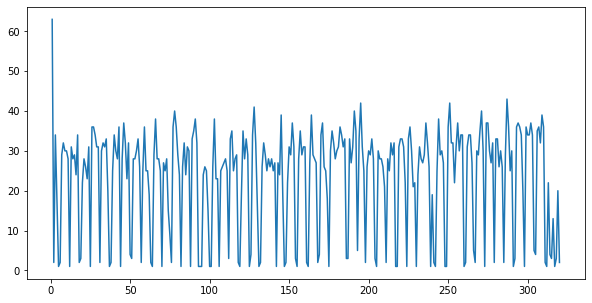

In [5]:
# Number of cases per day
plotData = data.groupby(['date']).agg(M=('patient_id', len)).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
p = ax.plot(plotData['date'], plotData['M'])

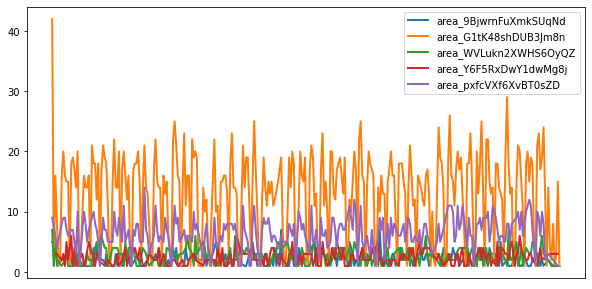

In [6]:
# Number of cases per day by area
plotData = data.groupby(['date', 'area']).agg(M=('patient_id', len)).reset_index().groupby('area')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for area, d in plotData:
    ax.plot(d['date'], d.M, marker='', linestyle='-', ms=2, linewidth=2, label=area)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

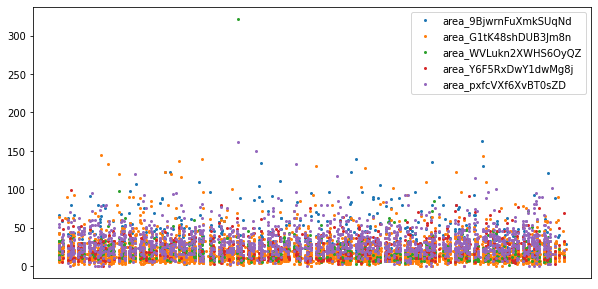

In [7]:
# Duration by area
plotData = data.groupby('area')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for area, d in plotData:
    ax.plot(d['date'], d['duration'], marker='o', linestyle='', ms=2, label=area)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

In [8]:
# Average number of cases and case duration per day by area
data.groupby(['date', 'area']).agg(
    n_cases=('patient_id', len),
    duration=('duration', np.mean),
).groupby('area').agg(
    n_cases=('n_cases', np.mean),
    duration=('duration', np.mean)
).reset_index()

,area,n_cases,duration
0,area_9BjwrnFuXmkSUqNd,2.284444,41.958910
1,area_G1tK48shDUB3Jm8n,12.904153,19.134803
2,area_WVLukn2XWHS6OyQZ,2.730769,20.371909
3,area_Y6F5RxDwY1dwMg8j,2.448889,25.830593
4,area_pxfcVXf6XvBT0sZD,6.638132,31.293970


# Select data for training and testing

In [9]:
# Select a split for training and testing
sel = data.groupby(['date']).agg(
    n_cases=('patient_id', len)
).reset_index().sort_values(by='date')

sel['n_cases'] = sel.n_cases.cumsum()

sel['percent_cases'] = sel.n_cases / max(sel.n_cases)

# Split at
share_train = 0.80

test_start_date = min(sel.loc[sel.percent_cases > share_train].date)

test_start_date

257

In [10]:
# Add identifier for train vs test data
data['train_test'] = ''
data.loc[data.date < test_start_date, 'train_test'] = 'train'
data.loc[data.date >= test_start_date, 'train_test'] = 'test'

In [11]:
# Inspect train-test split
train_test = data.groupby(['train_test', 'date']).agg(
    n_cases=('patient_id', len)
).reset_index().groupby('train_test').agg(
    n_cases=('n_cases', sum),
    n_days=('date', len)
).reset_index()

train_test['percent_cases'] = np.around(train_test['n_cases'] / sum(train_test['n_cases']) * 100, 1)
train_test['percent_days'] = np.around(train_test['n_days'] / sum(train_test['n_days']) * 100, 1)

train_test

,train_test,n_cases,n_days,percent_cases,percent_days
0,test,1478,64,20.0,20.0
1,train,5900,256,80.0,80.0


# Adding new features on surgeons and assistants

In [12]:
# All surgeons
surgeons = [col for col in data.columns if 'surgeon_' in col]

# All assistants
assistants = [col for col in data.columns if 'assistant_' in col]

## Team setup

In [13]:
# Number of surgeons
data['n_surgeons'] = data[surgeons].sum(axis=1)

# Number of assistants
data['n_assistants'] = data[surgeons].sum(axis=1)

# Total team size
data['team_size'] = data['n_surgeons'] + data['n_assistants']

## Team experience

In [14]:
# Number of cases per surgeon, assistant, team (in-sample)
surgeons_experience = data.loc[data.train_test == 'train', surgeons].sum(axis=0)
assistants_experience = data.loc[data.train_test == 'train', assistants].sum(axis=0)
team_experience = data.loc[data.train_test == 'train', surgeons+assistants].sum(axis=0)

# Average surgeon experience
data['surgeons_experience'] = data.apply(

    lambda df: sum(surgeons_experience[(df[surgeons] == 1)]) / 
        df['n_surgeons'] if df['n_surgeons'] > 0 else 0, axis=1
    
)

# Average assistant experience
data['assistants_experience'] = data.apply(

    lambda df: sum(assistants_experience[(df[assistants] == 1)]) / 
        df['n_assistants'] if df['n_assistants'] > 0 else 0, axis=1
    
)

# Average team experience
data['team_experience'] = data.apply(

    lambda df: sum(team_experience[(df[surgeons + assistants] == 1)]) / 
        df['team_size'] if df['team_size'] > 0 else 0, axis=1
    
)

# Room assignments

Room assignment is based on historical capacity ...

## Room capacities

In [15]:
def capacity_based_room_assignment(max_room_capacity, max_rooms, n_patients, durations):
    
    # Inputs
    if type(durations) == list:
        if not len(durations) == n_patients:
            
            raise ValueError('Length of durations should be n_patients')
            
    else:
        durations = [durations] * n_patients
    
    # Initialize
    current_capacity = 0
    room = 1
    rooms = []

    # For all patients
    for patient in range(n_patients):

        # Empty rooms are available
        if room < max_rooms:          

            # Current room has capacity available
            if current_capacity + durations[patient] <= max_room_capacity:

                # Add to rooms
                rooms += [room]

                # Update current capacity
                current_capacity += durations[patient]

            # Current room has no capacity available
            else:

                # Reset current capacity
                current_capacity = 0

                # New room
                room += 1

                # Add to rooms
                rooms += [room]

                # Update current capacity
                current_capacity += durations[patient]

        # No empty rooms are available
        else:

            # Overfill rooms            
            rooms += [(max_rooms + room) % max_rooms + 1]

            # Update shadow room counter
            room += 1
            
    return rooms

In [18]:
# Historically, 5 rooms were available
n_rooms = 5

# Calculate room capacity based on historical examination durations
hist_room_capacity = data.loc[data.train_test == 'train'].groupby('date').agg(
    day_capacity = ('duration', sum)).reset_index()
hist_room_capacity['room_capacity'] = hist_room_capacity['day_capacity'] / n_rooms

# Room capacity defined as median in-sample daily room capacity, adjusted for utilization
max_room_capacity = np.median(hist_room_capacity.room_capacity) / rho
max_room_capacity

119.30000000000001

## Historical examination durations by area

In [19]:
# Historical duration by area defined as median in-sample daily durations
historical_durations = data.loc[data.train_test == 'train'].groupby('area').agg(
    historical_median_duration = ('duration', np.median)).reset_index()

historical_durations

,area,historical_median_duration
0,area_9BjwrnFuXmkSUqNd,35.0
1,area_G1tK48shDUB3Jm8n,12.0
2,area_WVLukn2XWHS6OyQZ,17.0
3,area_Y6F5RxDwY1dwMg8j,22.0
4,area_pxfcVXf6XvBT0sZD,27.0


## Room assignment by area

In [23]:
# Test dates
dates = sorted(data.loc[data.train_test == 'test'].date.unique())
dates = sorted(data.date.unique())

# Initialize
room_assignments = []

# For each test date
for date in dates:

    # Areas 
    areas = sorted(data.loc[data.date == date].area.unique())
    
    # Room counter
    room_counter = 0
    
    # For each area
    for area in areas:
        
        # Select data
        patients = data.loc[(data.date == date) & (data.area == area)].patient_id
        n_patients = len(patients)
        durations = historical_durations.loc[historical_durations.area == area].historical_median_duration.item()
        
        # Assign rooms 
        rooms = capacity_based_room_assignment(max_room_capacity, max_rooms, n_patients, durations)
        
        # Adjust for rooms already asigned
        rooms = list(np.array(rooms) + room_counter)
        
        # Update room counter
        room_counter = max(rooms)
        
        # Store
        room_assignments += [pd.DataFrame(dict(date=[date]*n_patients, 
                                               patient_id = patients, 
                                               area=[area]*n_patients, 
                                               room=rooms))]
        
# Finalize
room_assignments = pd.concat(room_assignments)

In [24]:
room_assignments

,date,patient_id,area,room
7,1,patient_Y8xfdQUxNaeXjzOpVmIggoLnByjN5B2j,area_9BjwrnFuXmkSUqNd,1
8,1,patient_NZYE6dECcZzQgnLvaU9Yd5MFDPlmg13G,area_9BjwrnFuXmkSUqNd,1
9,1,patient_43uaISxAdZjJhkByKL517ZCPntW9BHcU,area_9BjwrnFuXmkSUqNd,1
15,1,patient_jhepPOjMim6i23k9i5WU76Dhd09zMmXK,area_9BjwrnFuXmkSUqNd,2
43,1,patient_ZVrPtnk8JrQJs1XU1xgHJqCRw7PoDcaV,area_9BjwrnFuXmkSUqNd,2
...,...,...,...,...
7373,319,patient_pb77XPNGvRBBZjXKuCe5H4oSYhq2H8eJ,area_Y6F5RxDwY1dwMg8j,4
7375,319,patient_eBZm68igXbwlTqQppeEfJWZtdIRmssH9,area_Y6F5RxDwY1dwMg8j,4
7370,319,patient_sdZHUmyZJToYJ9Bl6dDA4fHOQN4ov9e5,area_pxfcVXf6XvBT0sZD,5
7377,320,patient_upObPf0BxKtOoixmpakh8r1cvwpZwkI9,area_9BjwrnFuXmkSUqNd,1


In [26]:
# Add rooms assignments to data
data = pd.merge(

    left=data,
    right=room_assignments,
    on=['date', 'area', 'patient_id']

)

# Finalize and save

In [28]:
# These columns will be used as identifiers
identifiers = ['date', 'area', 'room', 'patient_id', 'train_test']

In [29]:
# Response
Y = data['duration']

In [30]:
# Features
X = data.drop(['duration']+identifiers, axis=1)

In [31]:
# Identifiers
ID = data[identifiers]

In [32]:
# Save
Y.to_csv('/home/fesc/dddex/PatientScheduling/Data/Y_data.csv', sep=',', index=False)
X.to_csv('/home/fesc/dddex/PatientScheduling/Data/X_data.csv', sep=',', index=False)
ID.to_csv('/home/fesc/dddex/PatientScheduling/Data/ID_data.csv', sep=',', index=False)

# <<<<< ARCHIVE >>>>>

In [ ]:
# Capacity
def capacity(y_train, areas_train, rho, which = None):

    """


    ...

    Arguments:

        y_train: np.array(n,) durations in training data
        areas_train: np.array(n,) treatment area for each value in y_train
        rho: utilization (duration scaling factor)
        which = None: one of 'median' or 'mean' defining which calculation logic to apply

    """

    # Ensure we have flat np.arrays
    y_train = np.array(y_train).flatten()
    areas_train = np.array(areas_train).flatten()

    # Check inputs
    if len(y_train) != len(areas_train):

        raise ValueError('y_train and areas_train have to be of the same length.')


    ## Based on median historical duration per area

    # Historical durations
    hist_durations = pd.DataFrame({
        'duration': y_train, 
        'area': areas_train,
    }).groupby('area').agg(
        median_duration=('duration', np.median)
    ).reset_index()

    median_durations_by_area = dict(zip(hist_durations.area, hist_durations.median_duration / rho))


    ## Based on mean historical duration per area

    # Historical durations
    hist_durations = pd.DataFrame({
        'duration': y_train, 
        'area': areas_train,
    }).groupby('area').agg(
        mean_duration=('duration', np.mean)
    ).reset_index()

    mean_durations_by_area = dict(zip(hist_durations.area, hist_durations.mean_duration / rho))


    ## Finalize
    time_budgets = {'median': median_durations_by_area, 'mean': mean_durations_by_area}

    return time_budgets.get(which, time_budgets)


# Select and prepare data for training and testing

## Randomized patient sequence

In [ ]:
# Function to get random sequence of data frame rows
def random_sequence(df):
    
    rs = np.array(df.index)
    np.random.shuffle(rs)
    
    return rs

# Get patient sequence per date
patient_sequence = data.groupby('date').apply(

    lambda df: pd.DataFrame({'seq': random_sequence(df)})

).seq.values

# Apply randomized patient sequence per date
data = data.iloc[patient_sequence]

# Ensure data is sorted by date
data = data.sort_values('date')

## Randomized room assignments

In [ ]:
def assign_rooms(patients, n_rooms):
    
    # Initialize rooms
    rooms = list(np.arange(n_rooms) + 1)
    
    # Initialize patient-room assignment
    patients_x_rooms = copy.deepcopy(patients)
    patients_x_rooms['room'] = 0
    
    # While not all patients have been assigned a room
    while sum(patients_x_rooms['room'] == 0) > 0:

        # Iterate over available rooms
        for room in rooms:

            # Skip if all patients have been assigned
            if sum(patients_x_rooms['room'] == 0) == 0:

                continue

            # Draw patient from patients without room
            idx = np.random.choice(patients_x_rooms.loc[patients_x_rooms.room == 0].index)

            # Assign patient to room
            patients_x_rooms.loc[patients_x_rooms.index == idx, 'room'] = room
            
    return patients_x_rooms

### Prepare room assignments

In [ ]:
# Initialize
data_test = data.loc[data.train_test == 'test', ['date', 'patient_id']]

# Number of cases per test date
dates_x_patients = data_test.groupby('date').agg(n_patients=('patient_id', len)).reset_index()

# Median number of cases per test date
np.median(dates_x_patients.n_patients)

In [ ]:
# Set max number of rooms
max_rooms = 5

# Get room capacity cut-off
max_capacity = np.median(dates_x_patients.n_patients) / max_rooms

In [ ]:
# Specify number of rooms on each test date
dates_x_patients['n_rooms'] = [
    
    min([max_rooms, math.ceil(n_patients / max_capacity)]) 
    for n_patients in dates_x_patients.n_patients

]

In [ ]:
# Check how many cases per room
dates_x_patients['n_patients_per_room'] = dates_x_patients.n_patients / dates_x_patients.n_rooms

# Median number of patients per room
np.median(dates_x_patients.n_patients_per_room)

In [ ]:
# Add number of rooms to test data
data_test = pd.merge(
    left=data_test,
    right=dates_x_patients[['date', 'n_rooms', 'n_patients_per_room']],
    on='date'
)

### Randomized iterative assignments

In [ ]:
# Test dates
dates = data_test['date'].unique()

# Initialize
patients_x_rooms = pd.DataFrame()

# For each test date
for date in dates:
    
    # Data for this test date
    patients = data_test.loc[data_test['date'] == date, ['date', 'patient_id']].copy()

    # Number of rooms for this test date
    n_rooms = dates_x_patients.loc[dates_x_patients['date'] == date, 'n_rooms'].item()

    # Random room assignments for this test date
    patients_x_rooms_ = assign_rooms(patients, n_rooms)
    
    # Add
    patients_x_rooms = pd.concat([patients_x_rooms, patients_x_rooms_])
    
# Merge room assignments to test data
data_test = pd.merge(
    left=data_test,
    right=patients_x_rooms,
    on=['date', 'patient_id']
)

In [ ]:
# Add room assignment in test horizon back to full data
data = pd.merge(
    left=data,
    right=data_test,
    on=['date', 'patient_id'],
    how='left'
)